In [1]:
### Imports
import gzip
from collections import defaultdict
import math
import numpy as np
import string
import random
import string
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns
import pandas as pd
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
### EVALUATION / METRICS
######################################
def convert_to_np_array(A):
    """
    If A is not already an array, convert it to an array
    """
    if not isinstance(A, np.ndarray): return np.array(A)
    else: return A

def get_MSE(A, B):
    """
    Given list A and list B:
    Return the mean squared error between A and B
    """
    return np.mean((convert_to_np_array(A) - convert_to_np_array(B))**2)

def inner(A, B):
    """
    Return the dot product between list A and list B
    """
    return np.dot(convert_to_np_array(A), convert_to_np_array(B))

def get_SSE(A, B):
    """
    Given list A and list B:
    Return the sum of squared errors between A and B
    """
    return np.sum((convert_to_np_array(A) - convert_to_np_array(B))**2)

def get_SE(A,B):
    """
    Given list A and list B:
    Return the squared error between each element
    """
    return (convert_to_np_array(A) - convert_to_np_array(B))**2

In [3]:
### SIMILARITY FUNCTIONS
######################################
def jaccard_sim(A,B):
    """
    Return the Jaccard similarity between list A and list B
    """
    if not isinstance(A, set): A = set(A)
    if not isinstance(B, set): B = set(B)
    n_intersect = len(A.intersection(B))
    n_union = len(A.union(B))
    if n_union == 0: return 0

    return n_intersect / n_union

def cosine_sim_binary(A,B, denom_over_all=True):
    """
    Return the cosine similarity between set A and set B (Binary interactions)
    """
    if not isinstance(A, set): A = set(A)
    if not isinstance(B, set): B = set(B)
    n_intersect = len(A.intersection(B))

    if denom_over_all:
        total_interactions = np.sqrt(len(A) * len(B))
    else:
        total_interactions = n_intersect
    if total_interactions == 0:
        return 0
    return n_intersect / total_interactions

############# Design structures to record shared items
def cosine_sim(x_tuple, y_tuple, denom_over_all):
    """
    Calculate the cosine similarity between lists x and y
    Input are lists of tuples: [(id1, rating), (id2, rating), ...]
    """
    # Get shared items
    x_ids, y_ids = set(), set()
    x_ratings, y_ratings = [], []
    shared_ratings_x, shared_ratings_y = [], []
    shared_tuples_x, shared_tuples_y = [], []
    for tuple in x_tuple:
        x_ids.add(tuple[0])
        x_ratings.append(tuple[1])
    for tuple in y_tuple:
        y_ids.add(tuple[0])
        y_ratings.append(tuple[1])
    shared_ids = x_ids.intersection(y_ids)

    shared_tuples_x = [tuple for tuple in x_tuple if tuple[0] in shared_ids]
    shared_tuples_x.sort()
    shared_tuples_y = [tuple for tuple in y_tuple if tuple[0] in shared_ids]
    shared_tuples_y.sort()
    shared_ratings_x = [tuple[1] for tuple in shared_tuples_x]
    shared_ratings_y = [tuple[1] for tuple in shared_tuples_y]

    if denom_over_all:
        # Use all items in the denominator
        x_norm = np.sum([xi**2 for xi in x_ratings])
        y_norm = np.sum([yi**2 for yi in y_ratings])
    else:
        # Only use shared items in the denominator
        x_norm = np.sum([xi**2 for xi in shared_ratings_x])
        y_norm = np.sum([yi**2 for yi in shared_ratings_y])
    denom = np.sqrt(x_norm) * np.sqrt(y_norm)

    if denom == 0: return 0
    numer = sum([xi*yi for xi,yi in zip(shared_ratings_x, shared_ratings_y)])

    return numer / denom

def pearson_sim(x_tuple, y_tuple):
    """
    Calculate the pearson similarity between lists x and y
    Input are lists of tuples: [(id1, rating), (id2, rating), ...]
    Unlike Cosine sim, ONLY shared items can be considered
    If id1 or id2 is not in the relevant training data structure, use meanValue as its respective mean
    """
    # Unpack averages
    x_avgs = {tuple[0][0]:tuple[1] for tuple in x_tuple}
    y_avgs = {tuple[0][0]:tuple[1] for tuple in y_tuple}
    # Get shared items
    shared_ratings_x, shared_ratings_y = [], []
    shared_tuples_x, shared_tuples_y = [], []
    x_ids = {tuple[0][0] for tuple in x_tuple}
    y_ids = {tuple[0][0] for tuple in y_tuple}
    shared_ids = x_ids.intersection(y_ids)

    shared_tuples_x = [tuple[0] for tuple in x_tuple if tuple[0][0] in shared_ids]
    shared_tuples_x.sort()
    shared_tuples_y = [tuple[0] for tuple in y_tuple if tuple[0][0] in shared_ids]
    shared_tuples_y.sort()
    shared_ratings_x = [tuple[1] - x_avgs[tuple[0]] for tuple in shared_tuples_x] ### Pearson --> Subtract the mean from each value
    shared_ratings_y = [tuple[1] - y_avgs[tuple[0]] for tuple in shared_tuples_y]

    # Only use shared items in the denominator
    x_norm = np.sum([xi**2 for xi in shared_ratings_x])
    y_norm = np.sum([yi**2 for yi in shared_ratings_y])
    denom = np.sqrt(x_norm * y_norm)

    if denom == 0: return 0
    numer = sum([xi*yi for xi,yi in zip(shared_ratings_x, shared_ratings_y)])

    return numer / denom


In [4]:
### COLLABORATIVE FILTERING
######################################
def predictValue_bySim(user_id, item_id, sim_func, type, meanValue, value_bounds=None, denom_over_all=None, **kwargs):
    """
    Predict some value (e.g., rating) that the user (user_id) will give an item (item_id) based on
    the input simularity function (sim_func).

    # Necessary Data Structures --> These are built using training data ONLY:
    itemsPerUser: A dictionary containing the list of items each user interacted with and corresponding values
       ex: itemsPerUser[user1] = [(item1, 2), (item3, 1), (item5, 5), ...]
    usersPerItem: A dictionary containing the list of users that interacted with each item and corresponding values
       ex: usersPerItem[item1] = [(user1, 2), (user4, 2), (user27, 2), ...]
    itemAverages: A dictionary containing the mean value for each item (For Pearson Similarity)
    userAverages: A dictionary containing the mean value for each user (For Pearson Similarity)
    #--- value_bounds: The min/max values that can be outputted as typically there's a scale (e.g., 1-5 stars)
    #--- meanValue: The mean of all values in valueDict.values()

    # Gathering similarity weights:
    If type==0:
       # Predict the rating as a weighted sum of ratings that user_id has given to other items #
       For each item (item_id2) that user_id has interacted with (except for item_id):
          Calculate item_id2's similarity to item_id based on shared user interactions
          Track these values as similarity weights
    else:
       # Predict the rating as a weighted sum of ratings that other users have given to item_id #
       For each user (user_id2) that have interacted with item_id (except for user_id):
          Calculate user_id2's similarity to user_id based on shared item interactions
          Track these values as similarity weights
    """

    # Edge case 1: Return global mean value if user_id or item_id are unseen
    if (user_id not in itemsPerUser) or (item_id not in usersPerItem): return meanValue
    # Initialize variables
    if denom_over_all is None: denom_over_all = True
    if value_bounds is None: value_bounds = (-np.inf, np.inf)
    values, similarities = [], []

    if type == "item":
        # Predict the rating as a weighted combination of how other items rated by user_id were
        # rated by similar users
        # if user_id not in userAverages: return meanValue # Skip keys that are not in the dict
        for user_id2,value in usersPerItem[item_id]:
            if user_id2 == user_id: continue
            # if user_id2 not in userAverages: continue  # Skip keys that are not in the dict
            if sim_func == jaccard_sim:
                simset_user_id = {tuple[0] for tuple in itemsPerUser[user_id] if tuple[0] != item_id}
                simset_user_id2 = {tuple[0] for tuple in itemsPerUser[user_id2] if tuple[0] != item_id}
                similarities.append(sim_func(simset_user_id, simset_user_id2))
            elif sim_func == cosine_sim_binary:
                if denom_over_all is None: denom_over_all = True
                simset_user_id = {tuple[0] for tuple in itemsPerUser[user_id] if tuple[0] != item_id}
                simset_user_id2 = {tuple[0] for tuple in itemsPerUser[user_id2] if tuple[0] != item_id}
                similarities.append(sim_func(simset_user_id, simset_user_id2, denom_over_all))
            elif sim_func == cosine_sim:
                if denom_over_all is None: denom_over_all = True
                simset_user_id = {tuple for tuple in itemsPerUser[user_id] if tuple[0] != item_id}
                simset_user_id2 = {tuple for tuple in itemsPerUser[user_id2] if tuple[0] != item_id}
                similarities.append(sim_func(simset_user_id, simset_user_id2, denom_over_all))
            elif sim_func == pearson_sim:
                simset_user_id = {(tuple, itemAverages[tuple[0]]) for tuple in itemsPerUser[user_id] if tuple[0] != item_id}
                simset_user_id2 = {(tuple, itemAverages[tuple[0]]) for tuple in itemsPerUser[user_id2] if tuple[0] != item_id}
                similarities.append(sim_func(simset_user_id, simset_user_id2))
            else:
                # Sim function not programmed
                print("Invalid sim_func")
                return None
            values.append(value)
    else:
        # Predict user_id's rating of item_id based on a weighted combination of how other users who
        # rated item_id rated other items
        # if item_id not in itemAverages: return meanValue # Skip keys that are not in the dict
        for item_id2,value in itemsPerUser[user_id]:
            if item_id2 == item_id: continue
            # if item_id2 not in itemAverages: continue # Skip keys that are not in the dict
            if sim_func == jaccard_sim:
                simset_item_id = {tuple[0] for tuple in usersPerItem[item_id] if tuple[0] != user_id}
                simset_item_id2 = {tuple[0] for tuple in usersPerItem[item_id2] if tuple[0] != user_id}
                similarities.append(sim_func(simset_item_id, simset_item_id2))
            elif sim_func == cosine_sim_binary:
                if denom_over_all is None: denom_over_all = True
                simset_item_id = {tuple[0] for tuple in usersPerItem[item_id] if tuple[0] != user_id}
                simset_item_id2 = {tuple[0] for tuple in usersPerItem[item_id2] if tuple[0] != user_id}
                similarities.append(sim_func(simset_item_id, simset_item_id2, denom_over_all))
            elif sim_func == cosine_sim:
                if denom_over_all is None: denom_over_all = True
                simset_item_id = {tuple for tuple in usersPerItem[item_id] if tuple[0] != user_id}
                simset_item_id2 = {tuple for tuple in usersPerItem[item_id2] if tuple[0] != user_id}
                similarities.append(sim_func(simset_item_id, simset_item_id2, denom_over_all))
            elif sim_func == pearson_sim:
                simset_item_id = {(tuple, userAverages[tuple[0]]) for tuple in usersPerItem[item_id] if tuple[0] != user_id}
                simset_item_id2 = {(tuple, userAverages[tuple[0]]) for tuple in usersPerItem[item_id2] if tuple[0] != user_id}
                similarities.append(sim_func(simset_item_id, simset_item_id2))
            else:
                # Sim function not programmed
                print("Invalid sim_func")
                return None
            values.append(value)
    # Edge case 2: Return global mean value if there are no similar items
    if np.sum(similarities) == 0: return meanValue

    numerator = np.sum([value*sim for value,sim in zip(values, similarities)])
    denominator = np.sum(similarities)
    output = numerator / denominator
    if output < value_bounds[0]: return value_bounds[0]
    if output > value_bounds[1]: return value_bounds[1]

    return output

def predictValue_bySim_devFromMean(user_id, item_id, sim_func, type, meanValue, value_bounds=None, denom_over_all=None, **kwargs):
    """
    Predict some value (e.g., rating) that the user (user_id) will give an item (item_id) based on
    the input simularity function (sim_func). However, instead of predicting the rating directly,
    predict the deviation from the global mean rating

    # Necessary Data Structures --> These are built using training data ONLY
    itemsPerUser: A dictionary containing the list of items each user interacted with and corresponding values
       ex: itemsPerUser[user1] = [(item1, 2), (item3, 1), (item5, 5), ...]
    usersPerItem: A dictionary containing the list of users that interacted with each item and corresponding values
       ex: usersPerItem[item1] = [(user1, 2), (user4, 2), (user27, 2), ...]
    itemAverages: A dictionary containing the mean value for each item
    userAverages: A dictionary containing the mean value for each user
    #--- value_bounds: The min/max values that can be outputted as typically there's a scale (e.g., 1-5 stars)
    #--- meanValue: The mean of all values in valueDict.values()

    # Gathering similarity weights:
    If type==0:
       # Predict the rating as a weighted sum of ratings that user_id has given to other items #
       For each item (item_id2) that user_id has interacted with (except for item_id):
          Calculate item_id2's similarity to item_id based on shared user interactions
          Track these values as similarity weights
    else:
       # Predict the rating as a weighted sum of ratings that other users have given to item_id #
       For each user (user_id2) that have interacted with item_id (except for user_id):
          Calculate user_id2's similarity to user_id based on shared item interactions
          Track these values as similarity weights
    """
    # Edge case 1: Return global mean value if user_id or item_id are unseen
    if (user_id not in itemsPerUser) or (item_id not in usersPerItem): return meanValue
    # Initialize variables
    if denom_over_all is None: denom_over_all = True
    if value_bounds is None: value_bounds = (-np.inf, np.inf)
    values, similarities = [], []

    if type == "item":
        # Predict the rating as a weighted combination of how other items rated by user_id were
        # rated by similar users
        # if user_id not in userAverages: return meanValue # Skip keys that are not in the dict
        avg_value = userAverages[user_id]
        for user_id2,value in usersPerItem[item_id]:
            if user_id2 == user_id: continue
            # if user_id2 not in userAverages: continue  # Skip keys that are not in the dict
            if sim_func == jaccard_sim:
                simset_user_id = {tuple[0] for tuple in itemsPerUser[user_id] if tuple[0] != item_id}
                simset_user_id2 = {tuple[0] for tuple in itemsPerUser[user_id2] if tuple[0] != item_id}
                similarities.append(sim_func(simset_user_id, simset_user_id2))
            elif sim_func == cosine_sim_binary:
                if denom_over_all is None: denom_over_all = True
                simset_user_id = {tuple[0] for tuple in itemsPerUser[user_id] if tuple[0] != item_id}
                simset_user_id2 = {tuple[0] for tuple in itemsPerUser[user_id2] if tuple[0] != item_id}
                similarities.append(sim_func(simset_user_id, simset_user_id2, denom_over_all))
            elif sim_func == cosine_sim:
                if denom_over_all is None: denom_over_all = True
                simset_user_id = {tuple for tuple in itemsPerUser[user_id] if tuple[0] != item_id}
                simset_user_id2 = {tuple for tuple in itemsPerUser[user_id2] if tuple[0] != item_id}
                similarities.append(sim_func(simset_user_id, simset_user_id2, denom_over_all))
            elif sim_func == pearson_sim:
                simset_user_id = {(tuple, itemAverages[tuple[0]]) for tuple in itemsPerUser[user_id] if tuple[0] != item_id}
                simset_user_id2 = {(tuple, itemAverages[tuple[0]]) for tuple in itemsPerUser[user_id2] if tuple[0] != item_id}
                similarities.append(sim_func(simset_user_id, simset_user_id2))
            else:
                # Sim function not programmed
                print("Invalid sim_func")
                return None
            values.append(value - userAverages[user_id2])
    else:
        # Predict user_id's rating of item_id based on a weighted combination of how other users who
        # rated item_id rated other items
        # if item_id not in itemAverages: return meanValue # Skip keys that are not in the dict
        avg_value = itemAverages[item_id]
        for item_id2,value in itemsPerUser[user_id]:
            if item_id2 == item_id: continue
            # if item_id2 not in itemAverages: continue # Skip keys that are not in the dict
            if sim_func == jaccard_sim:
                simset_item_id = {tuple[0] for tuple in usersPerItem[item_id] if tuple[0] != user_id}
                simset_item_id2 = {tuple[0] for tuple in usersPerItem[item_id2] if tuple[0] != user_id}
                similarities.append(sim_func(simset_item_id, simset_item_id2))
            elif sim_func == cosine_sim_binary:
                if denom_over_all is None: denom_over_all = True
                simset_item_id = {tuple[0] for tuple in usersPerItem[item_id] if tuple[0] != user_id}
                simset_item_id2 = {tuple[0] for tuple in usersPerItem[item_id2] if tuple[0] != user_id}
                similarities.append(sim_func(simset_item_id, simset_item_id2, denom_over_all))
            elif sim_func == cosine_sim:
                if denom_over_all is None: denom_over_all = True
                simset_item_id = {tuple for tuple in usersPerItem[item_id] if tuple[0] != user_id}
                simset_item_id2 = {tuple for tuple in usersPerItem[item_id2] if tuple[0] != user_id}
                similarities.append(sim_func(simset_item_id, simset_item_id2, denom_over_all))
            elif sim_func == pearson_sim:
                simset_item_id = {(tuple, userAverages[tuple[0]]) for tuple in usersPerItem[item_id] if tuple[0] != user_id}
                simset_item_id2 = {(tuple, userAverages[tuple[0]]) for tuple in usersPerItem[item_id2] if tuple[0] != user_id}
                similarities.append(sim_func(simset_item_id, simset_item_id2))
            else:
                # Sim function not programmed
                print("Invalid sim_func")
                return None
            values.append(value - itemAverages[item_id2])
    # Edge case 2: Return global mean value if there are no similar items
    if np.sum(similarities) == 0: return meanValue

    numerator = np.sum([value*sim for value,sim in zip(values, similarities)])
    denominator = np.sum(similarities)
    output = avg_value + (numerator / denominator)
    if output < value_bounds[0]: return value_bounds[0]
    if output > value_bounds[1]: return value_bounds[1]

    return output

In [5]:
### LATENT FACTOR MODEL
######################################
def initialize_params(ratingDict, itemsPerUser, usersPerItem, k, init_bounds):
    """
    Return the initialized parameters
    """
    user_count, item_count = len(itemsPerUser), len(usersPerItem)
    lower, upper = init_bounds
    alpha = np.mean([i for i in ratingDict.values()])
    user_bias = dict(zip(users, [random.uniform(lower,upper) for i in range(user_count)]))
    item_bias = dict(zip(items, [random.uniform(lower,upper) for i in range(item_count)]))
    user_gamma = dict(zip(users, [[random.uniform(lower,upper) for ki in range(k)] for i in range(user_count)]))
    item_gamma = dict(zip(items, [[random.uniform(lower,upper) for ki in range(k)] for i in range(item_count)]))

    return (alpha, user_bias, item_bias, user_gamma, item_gamma)

def get_lfm_defaults(theta):
    """
    Calculate average values/vectors to use as default values for the latent factor predictions
    """
    alpha, user_bias, item_bias, user_gamma, item_gamma = theta
    avg_params = {}
    avg_params["avg_user_bias"] = np.mean(np.array([i for i in user_bias.values()]))
    avg_params["avg_item_bias"] = np.mean(np.array([i for i in item_bias.values()]))
    avg_params["avg_user_gamma"] = np.mean(np.array([values for values in user_gamma.values()]), axis=0)
    avg_params["avg_item_gamma"] = np.mean(np.array([values for values in item_gamma.values()]), axis=0)

    return avg_params

def predict_latent_factor(u_id, item_id, theta, value_bounds = None, avg_params = None):
    """
    Return the prediction based on u_id and item_id
    If u_id is not in itemsPerUser --> Use the average gamma vector
    Repeat this process for if item_id is not in usersPerItem

    Bound the output by the min and max of the possible values 
    (ex: Model shouldn't exceed 5 when the scale is 5)
    """
    if value_bounds is None: value_bounds = (-np.inf, np.inf)
    alpha, user_bias, item_bias, user_gamma, item_gamma = theta
    for i,(gamma_vec) in enumerate(user_gamma.values()):
        if i > 0: break
        k = len(gamma_vec)

    if u_id in user_bias: u_bias = user_bias[u_id]
    else:
        if (avg_params is not None) and (item_id in item_bias): u_bias = avg_params["avg_user_bias"]
        else: u_bias = 0

    if item_id in item_bias: i_bias = item_bias[item_id]
    else:
        if (avg_params is not None) and (u_id in user_bias): i_bias = avg_params["avg_item_bias"]
        else: i_bias = 0

    if u_id in user_gamma: u_gamma = np.array(user_gamma[u_id])
    else:
        if (avg_params is not None) and (item_id in item_gamma): u_gamma = avg_params["avg_user_gamma"]
        else: u_gamma = [0]*k

    if item_id in item_gamma: i_gamma = np.array(item_gamma[item_id])
    else:
        if (avg_params is not None) and (u_id in user_gamma): i_gamma = avg_params["avg_item_gamma"]
        else: i_gamma = [0]*k

    value = alpha + u_bias + i_bias + np.dot(u_gamma, i_gamma)
    if value < value_bounds[0]: return value_bounds[0]
    if value > value_bounds[1]: return value_bounds[1]

    return value

def get_cost(theta, lambda_bias, lambda_gamma, Xtrain, ytrain, k, value_bounds=None):
    """
    Calculate the cost for the given theta parameters
    Xtrain must be of form [(user, item), (user, item), ...]
    """
    alpha, user_bias, item_bias, user_gamma, item_gamma = theta
    # Predict using the current theta values
    predictions = np.array([predict_latent_factor(tuple[0], tuple[1], theta, value_bounds) for tuple in Xtrain])
    # Calculate SSE + regularization
    cost = get_SSE(predictions, ytrain)
    cost += lambda_bias * np.sum(np.array([val**2 for val in user_bias.values()]))
    cost += lambda_bias * np.sum(np.array([val**2 for val in item_bias.values()]))
    cost += lambda_gamma * np.sum(np.array([inner(gam, gam) for gam in user_gamma.values()]))
    cost += lambda_gamma * np.sum(np.array([inner(gam, gam) for gam in item_gamma.values()]))

    return cost

def update_params(theta, lambda_bias, lambda_gamma, Xtrain, ytrain, fix_value):
    """
    Update parameters based on how well they predict in their CURRENT states
    Coordinate descent instead of gradient descent for faster convergence
    ###
    Latent factor model
         Fix user_gamma --> iterate and update alpha, user_bias, item_gamma
         Fix item_gamma --> iterate and update alpha, user_bias, user_gamma
    Fix user_gamma... Fix item_gamma...
    Repeat the above until model have converged
    """
    alpha, user_bias, item_bias, user_gamma, item_gamma = theta
    # Iterate through the alpha and bias params
    if (fix_value == 0) or (fix_value == 4):
        # Calculate the new alpha
        alpha_sum = 0
        for tuple, rating in zip(Xtrain, ytrain):
            u_id, item_id = tuple
            alpha_sum += (rating - (user_bias[u_id] + item_bias[item_id] + inner(user_gamma[u_id], item_gamma[item_id])))
        dalpha = alpha_sum / N
        alpha = dalpha.copy()
    elif (fix_value == 1) or (fix_value == 5):
        # Calculate the new user bias
        duser_bias = {}
        for u_id in users:
            user_sum = 0
            users_item_count = len(itemsPerUser[u_id])
            for tuple in itemsPerUser[u_id]:
                item_id, rating = tuple
                user_sum += (rating - (alpha + item_bias[item_id] + inner(user_gamma[u_id], item_gamma[item_id])))
            duser_bias[u_id] = (user_sum * (1 / (users_item_count + lambda_bias)))
        user_bias = duser_bias.copy()
    elif (fix_value == 2) or (fix_value == 6):
        # Calculate the new item bias
        ditem_bias = {}
        for item_id in items:
            item_sum = 0
            items_user_count = len(usersPerItem[item_id])
            for tuple in usersPerItem[item_id]:
                u_id, rating = tuple
                item_sum += (rating - (alpha + user_bias[u_id] + inner(user_gamma[u_id], item_gamma[item_id])))
            ditem_bias[item_id] = (item_sum * (1 / (items_user_count + lambda_bias)))
        item_bias = ditem_bias.copy()
    elif fix_value == 3:
        # Calculate the new user gamma
        duser_gamma = {}
        for u_id in users:
            user_sums = [0] * k
            i_gamma_k_sqrd_sums = [0] * k
            users_item_count = len(itemsPerUser[u_id])
            for tuple in itemsPerUser[u_id]:
                item_id, rating = tuple
                # Update each user's gamma value
                for ki in range(k):
                    i_gamma_k = item_gamma[item_id][ki]
                    i_gamma_k_sqrd_sums[ki] += i_gamma_k**2
                    user_sums[ki] = i_gamma_k * (rating - (alpha + user_bias[u_id] + item_bias[item_id]))
            duser_gamma[u_id] = [user_sums[ki] * (1 / (users_item_count*i_gamma_k_sqrd_sums[ki] + lambda_gamma)) for ki in range(k)]
        user_gamma = duser_gamma.copy()
    elif fix_value == 7:
         # Calculate the new item gamma
        ditem_gamma = {}
        for item_id in items:
            item_sums = [0] * k
            u_gamma_k_sqrd_sums = [0] * k
            items_user_count = len(usersPerItem[item_id])
            for tuple in usersPerItem[item_id]:
                u_id, rating = tuple
                # Update each item's gamma value
                for ki in range(k):
                    u_gamma_k = user_gamma[u_id][ki]
                    u_gamma_k_sqrd_sums[ki] += u_gamma_k**2
                    item_sums[ki] = u_gamma_k * (rating - (alpha + user_bias[u_id] + item_bias[item_id]))
            ditem_gamma[item_id] = [item_sums[ki] * (1 / (items_user_count*u_gamma_k_sqrd_sums[ki] + lambda_gamma)) for ki in range(k)]
        item_gamma = ditem_gamma.copy()

    return (alpha, user_bias, item_bias, user_gamma, item_gamma)

def fit_parameters(Xtrain, ytrain, theta, ep=0.0005, iter_limit=200, quiet=True, value_bounds=(-np.inf, np.inf), check_every=10, **kwargs):
    """
    Fit the parameters until convergence (when difference in cost is less than ep)
    Arguments packed into **kwargs:
    lambda_bias --> Regularization parameter for the user/item biases
    lambda_gamma --> Regularization parameter for the user/item gamma matrix
    k --> Number of latent parameters to use per user/item vector
    ep --> The threshold for early stopping between mse checks
    iter_limit --> The maximum number of iterations allowed
    value_bounds --> The expected range of values expected to be outputted by the model
    check_every --> Calculate the cost/mse whenever iter_count is perfectly divisible by check_every (ex: check_every=10 means check every 10 iterations)
    """
    last_mse, last_cost = np.inf, np.inf
    best_params = [theta, last_mse, last_cost]

    iter_count = 0
    while True:
        # Track iteration count as well as which parameter to update (fix_value)
        iter_count += 1
        fix_value = (iter_count - 1) % 8

        # Update theta
        theta = update_params(theta, lambda_bias, lambda_gamma, Xtrain, ytrain, fix_value)

        # Every few iterations, check cost and mse
        if (iter_count % check_every == 0):
            cost = get_cost(theta, lambda_bias, lambda_gamma, Xtrain, ytrain, k, value_bounds)
            predictions = np.array([predict_latent_factor(tuple[0], tuple[1], theta, value_bounds) for tuple in Xtrain])
            mse = get_MSE(predictions, ytrain)
            if not quiet:
                print(f"Iteration {iter_count}: Cost = {cost}, Train MSE = {mse}")
            ### Check cost/mse
            # Save current params as best_params if the mse is less than the last mse
            if mse < best_params[1]:
                best_params = [theta, mse, cost]
                # If the difference in cost is less than ep, stop iterating
                if last_mse - mse > ep:
                    last_mse = mse
                    last_cost = cost
                else:
                    if not quiet:
                        print(f"Convergence after {iter_count} iterations: Cost = {cost}, Train MSE = {mse}")
                    break
            # Check if cost is too high - sometimes the algorithm diverges
            if mse > 5000:
                theta, mse, cost = best_params
                if not quiet:
                    print(f"Training MSE too high: Best Train MSE = {best_params[1]}")
                break
        # If the iteration limit is reached, stop and return the best parameters
        if iter_count > iter_limit:
            theta, mse, cost = best_params
            if not quiet:
                print(f"Iteration limit reached after {iter_count} iterations: Best Train MSE = {best_params[1]}")
            break

    return (theta, cost, mse)


In [6]:
### OTHER HELPFUL FUNCTIONS
######################################
def get_rec_structs(train_data):
    """
    Extract stats used for creating the classifier features
    Input is (user_id, item_id, value), ...
    Typically value is rating, but can be other things (e.g., hours played)

    itemsPerUser: Records each item in the training set that each user interacted with (along with the corresponding value)
    usersPerItem: Records each user in the training set that each item interacted with (along with the corresponding value)
    valueDict: Records the value for each (user, item) tuple
    userAverages: Gives the average value for each user
    itemAverages: Gives the average value for each item
    """
    ### Record which items each user interacted with and which users interacted with which item
    itemsPerUser = defaultdict(list)
    usersPerItem = defaultdict(list)
    valueDict = {}
    for u,b,v in train_data:
        itemsPerUser[u].append((b,v))
        usersPerItem[b].append((u,v))
        valueDict[(u,b)] = v

    ### Calculate user and item average ratings
    userAverages = {}
    itemAverages = {}
    for u,tuples in itemsPerUser.items():
        values = [value for item,value in tuples]
        # values = [value for item,value in tuples if value != 0]
        # if len(values) == 0: continue
        userAverages[u] = sum(values) / len(values)
    for i,tuples in usersPerItem.items():
        values = [value for user,value in tuples]
        # values = [value for user,value in tuples if value != 0]
        # if len(values) == 0: continue
        itemAverages[i] = sum(values) / len(values)

    rec_structs = {"itemsPerUser":itemsPerUser,
                  "usersPerItem":usersPerItem,
                  "valueDict":valueDict,
                  "userAverages":userAverages,
                  "itemAverages":itemAverages,}

    return rec_structs

def unpack_rec_structs(rec_structs):
    """
    Take the input recommender_structs and return the itemized contents
    """
    itemsPerUser = rec_structs["itemsPerUser"]
    usersPerItem = rec_structs["usersPerItem"]
    valueDict = rec_structs["valueDict"]
    userAverages = rec_structs["userAverages"]
    itemAverages = rec_structs["itemAverages"]

    return (itemsPerUser, usersPerItem, valueDict, userAverages, itemAverages)

### Functions to read files (From homework stubs)
def readGz(path):
    output = []
    for l in gzip.open(path, mode = 'rt', encoding = "utf-8"):
        output.append(eval(l))
    return output
    #

def readGz_item(path, key, columns = None):
    output_dict = {}
    counter = 0
    for i,(l) in enumerate(gzip.open(path, mode = 'rt', encoding = "utf-8")):
        counter += 1
        if counter==10: break

        row = eval(l)

        output_dict[key] = {col:row[col] for col in columns}

    return output_dict

def anonymize_column(df, col, col_dict=None):
    """
    Use a dictionary to randomly assign a new id to each value
    """
    values = list(df[col].unique())
    random.shuffle(values)
    if col_dict:
        df[col] = df[col].map(col_dict)
    else:
        col_dict = {value:f"u{i}" for i,value in enumerate(values)}
        df[col] = df[col].map(col_dict)

    return (df, col_dict)


def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        u,b,r = l.strip().split(',')
        r = int(r)
        yield u,b,r

# genre clusters?
def get_ohe_df(df, key, col):
    """
    Output a new df where the input col is ohe into separate columns
    """
    # Filter out any NA values
    df2 = df[df[col].notna()].reset_index().copy()
    
    # Get the set of all possible values
    values = set()
    for col_values in df2[col].to_list():
        if isinstance(col_values, float):
            values.add(col_values)
        else:
            for value in col_values:
                values.add(value)

    # Build up output df
    output = []
    for i in range(len(df2)):
        value_counts = {value:0 for value in values}
        value_counts[key] = df2.loc[i,key]
        for col_values in df2.loc[i,col]:
            if isinstance(col_values, list):
                for value in col_values:
                    value_counts[value] += 1
            else:
                value_counts[col_values] += 1
        output.append(value_counts)

    return pd.DataFrame(output).set_index(key, drop=True)


In [7]:
%%time
### Load all user data
user_df = readGz("data/australian_users_items.json.gz")
user_df = pd.DataFrame(user_df)

CPU times: total: 42.5 s
Wall time: 42.7 s


In [8]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88310 entries, 0 to 88309
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      88310 non-null  object
 1   items_count  88310 non-null  int64 
 2   steam_id     88310 non-null  object
 3   user_url     88310 non-null  object
 4   items        88310 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


In [9]:
### Reduce the dataset to make computations faster
seed = 100
user_df = user_df.sample(frac=1).iloc[:20000,:]

In [10]:
# Extract a new df that has [user_id, game_id, playtime] columns --> playtime_df
# Extract a dictionary that only contains the user_id and relevant item information
# Extract a secondary user df with recently played games
itemsPerUser = {}
playtime_df = []
for i in range(len(user_df)):
    user_id, user_items = user_df.iloc[i,:]["steam_id"], user_df.iloc[i,:]["items"]
    item_tuples = []
    for user_item in user_items:
        playtime_df.append({"user_id":user_id, \
                            "item_id":int(user_item["item_id"]), \
                            "playtime":user_item["playtime_forever"], \
                            "recent_playtime":user_item["playtime_2weeks"]})
        item_tuples.append((user_item["item_id"], user_item["playtime_forever"]))
playtime_df = pd.DataFrame(playtime_df)

playtime_df

,user_id,item_id,playtime,recent_playtime
0,76561197965981411,10,0,0
1,76561197965981411,20,0,0
2,76561197965981411,30,0,0
3,76561197965981411,40,0,0
4,76561197965981411,50,0,0
...,...,...,...,...
1197241,76561198057775965,105450,528,0
1197242,76561198057775965,221380,2109,0
1197243,76561198057775965,355950,0,0
1197244,76561198057775965,359550,4736,40


In [11]:
### Sample a set number of rows
playtime_df = playtime_df.sample(frac=1).iloc[:850000,:]

In [12]:
### PREPROCESS THE USER_DF
n_plays_cutoff = 3

n_users = len(playtime_df["user_id"].unique())
print(f"# users in the dataset: {n_users}")

# Duplicate analysis
n_duplicated = len(playtime_df[playtime_df.duplicated()])
playtime_df = playtime_df.drop_duplicates()
print(f"Number of duplicate entries to drop from the dataset: {n_duplicated}")

# Find all users with fewer than n_plays_cutoff itemscount --> To be removed from dataset
users_fewerThanNItems = list(playtime_df["user_id"].value_counts()[playtime_df["user_id"].value_counts() < n_plays_cutoff].index)
n_fewerThanNItems = len(users_fewerThanNItems)
print(f"# users with fewer than {n_plays_cutoff} items: {n_fewerThanNItems}")

# Filter out all users with 0 sum playtime
users_zeroPlaytime = playtime_df[["user_id","playtime"]].groupby("user_id").agg("sum")
users_zeroPlaytime = []# list(users_zeroPlaytime[users_zeroPlaytime["playtime"] == 0].index)
n_zeroPlaytime = len(users_zeroPlaytime)
print(f"# users with zero total playtime: {n_zeroPlaytime}")

# filter_out = set(users_fewerThan4Items + users_zeroPlaytime)
filter_out = set(users_fewerThanNItems + users_zeroPlaytime)
n_filter_out = len(filter_out)
print("#-----")
print(f"Total number of users to filter out of the dataset: {n_filter_out}")
print(f"Total number of users remaining: {n_users - n_filter_out}")

playtime_df = playtime_df[~playtime_df["user_id"].isin(filter_out)]

# Anonymize the user_ids
playtime_df, user_dict = anonymize_column(playtime_df, "user_id")

# Due to extreme outlier values, create a log version of the playtime column
playtime_df["playtime_log"] = playtime_df["playtime"].apply(lambda x: math.log(x + 1))
playtime_df["recent_playtime_log"] = playtime_df["recent_playtime"].apply(lambda x: math.log(x + 1))

# Create a binary version of the playtime column
playtime_df["playtime_binary"] = playtime_df["playtime"].map(lambda x: 0 if x==0 else 1)
playtime_df["recent_playtime_binary"] = playtime_df["recent_playtime"].map(lambda x: 0 if x==0 else 1)

# users in the dataset: 15838
Number of duplicate entries to drop from the dataset: 2137
# users with fewer than 3 items: 1269
# users with zero total playtime: 0
#-----
Total number of users to filter out of the dataset: 1269
Total number of users remaining: 14569


In [13]:
# ### PREPROCESS THE USER_DF
# n_users = len(user_df)
# print(f"# users in the dataset: {n_users}")

# # Find all users with fewer than 4 itemscount --> To be removed from dataset
# users_fewerThan4Items = list(user_df[user_df["items_count"] < 4]["steam_id"].unique())
# n_fewerThan4Items = len(users_fewerThan4Items)
# print(f"# users with fewer than 4 items: {n_fewerThan4Items}")

# # Extract a new df that has [user_id, game_id, playtime] columns --> playtime_df
# # Extract a dictionary that only contains the user_id and relevant item information
# # Extract a secondary user df with recently played games
# itemsPerUser = {}
# playtime_df = []
# for i in range(len(user_df)):
#     user_id, user_items = user_df.iloc[i,:]["steam_id"], user_df.iloc[i,:]["items"]
#     item_tuples = []
#     for user_item in user_items:
#         playtime_df.append({"user_id":user_id, \
#                             "item_id":int(user_item["item_id"]), \
#                             "playtime":user_item["playtime_forever"], \
#                             "recent_playtime":user_item["playtime_2weeks"]})
#         item_tuples.append((user_item["item_id"], user_item["playtime_forever"]))
# playtime_df = pd.DataFrame(playtime_df)

# # Duplicate analysis
# n_duplicated = len(playtime_df[playtime_df.duplicated()])
# playtime_df = playtime_df.drop_duplicates()

# print(f"Number of duplicate entries to drop from the dataset: {n_duplicated}")

# # Filter out all users with 0 sum playtime
# # users_zeroPlaytime = playtime_df[["user_id","playtime"]].groupby("user_id").agg("sum")
# # users_zeroPlaytime = list(users_zeroPlaytime[users_zeroPlaytime["playtime"] == 0].index)
# # n_zeroPlaytime = len(users_zeroPlaytime)
# # print(f"# users with zero total playtime: {n_zeroPlaytime}")

# # filter_out = set(users_fewerThan4Items + users_zeroPlaytime)
# filter_out = set(users_fewerThan4Items)
# n_filter_out = len(filter_out)
# print("#-----")
# print(f"Total number of users to filter out of the dataset: {n_filter_out}")
# print(f"Total number of users remaining: {n_users - n_filter_out}")

# playtime_df = playtime_df[~playtime_df["user_id"].isin(filter_out)]

# # Anonymize the user_ids
# playtime_df, user_dict = anonymize_column(playtime_df, "user_id")

# # Due to extreme outlier values, create a log version of the playtime column
# playtime_df["playtime_log"] = playtime_df["playtime"].apply(lambda x: math.log(x + 1))
# playtime_df["recent_playtime_log"] = playtime_df["recent_playtime"].apply(lambda x: math.log(x + 1))

# # Create a binary version of the playtime column
# playtime_df["playtime_binary"] = playtime_df["playtime"].map(lambda x: 0 if x==0 else 1)
# playtime_df["recent_playtime_binary"] = playtime_df["recent_playtime"].map(lambda x: 0 if x==0 else 1)

In [14]:
playtime_df.head(10)

,user_id,item_id,playtime,recent_playtime,playtime_log,recent_playtime_log,playtime_binary,recent_playtime_binary
50250,u579,32370,1806,0,7.499423,0.0,1,0
817766,u4817,385770,1441,0,7.273786,0.0,1,0
846261,u6730,12750,24,0,3.218876,0.0,1,0
651316,u10573,364360,2048,0,7.625107,0.0,1,0
29378,u8895,255520,14,0,2.708050,0.0,1,0
845004,u10872,80,3,0,1.386294,0.0,1,0
48602,u2323,22330,9,0,2.302585,0.0,1,0
524414,u9713,225300,0,0,0.000000,0.0,0,0
107864,u11386,65800,166,0,5.117994,0.0,1,0
514917,u9406,301910,0,0,0.000000,0.0,0,0


In [15]:
playtime_df.describe()

,item_id,playtime,recent_playtime,playtime_log,recent_playtime_log,playtime_binary,recent_playtime_binary
count,846137.000000,846137.000000,846137.000000,846137.000000,846137.000000,846137.000000,846137.000000
mean,180277.094787,966.299585,8.919381,3.306869,0.113530,0.632296,0.026886
std,132552.152716,5328.092682,142.015781,3.034587,0.755739,0.482181,0.161750
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35130.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,215100.000000,32.000000,0.000000,3.496508,0.000000,1.000000,0.000000
75%,270150.000000,340.000000,0.000000,5.831882,0.000000,1.000000,0.000000
max,530720.000000,613411.000000,19967.000000,13.326792,9.901886,1.000000,1.000000


In [16]:
# Number of games in playtime
len(playtime_df["item_id"].unique())

9669

In [17]:
playtime_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 846137 entries, 50250 to 128666
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   user_id                 846137 non-null  object 
 1   item_id                 846137 non-null  int64  
 2   playtime                846137 non-null  int64  
 3   recent_playtime         846137 non-null  int64  
 4   playtime_log            846137 non-null  float64
 5   recent_playtime_log     846137 non-null  float64
 6   playtime_binary         846137 non-null  int64  
 7   recent_playtime_binary  846137 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 58.1+ MB


In [46]:
%%time
### Load all game data
game_df = readGz("data/steam_games.json.gz")
game_df = pd.DataFrame(game_df)
game_df["id"] = pd.to_numeric(game_df["id"])

CPU times: total: 1.8 s
Wall time: 1.8 s


In [47]:
game_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  float64
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(2), object(13)
memory usage: 3.7+ MB


In [48]:
# Remove unnnecessary columns
keep_columns = ["id", "genres", "tags", "specs"]
game_df = game_df[keep_columns]

# Rename id column to item_id
key = "item_id"
game_df.rename(columns={"id":"item_id"}, inplace=True)

# Find all games without valid ids --> Remove
games_invalidID = game_df[game_df[key].isna()].index
game_df = game_df[~game_df[key].isin(games_invalidID)]


In [49]:
# Find any duplicate games
n_duplicateGames = len(game_df[game_df["item_id"].duplicated()])
game_df = game_df[~game_df["item_id"].isin(game_df[game_df["item_id"].duplicated()]["item_id"])]

print(f"Number of duplicate game entries to drop: {n_duplicateGames}")

Number of duplicate game entries to drop: 2


In [50]:
game_df

,item_id,genres,tags,specs
0,761140.0,"[Action, Casual, Indie, Simulation, Strategy]","[Strategy, Action, Indie, Casual, Simulation]",[Single-player]
1,643980.0,"[Free to Play, Indie, RPG, Strategy]","[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla..."
2,670290.0,"[Casual, Free to Play, Indie, Simulation, Sports]","[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla..."
3,767400.0,"[Action, Adventure, Casual]","[Action, Adventure, Casual]",[Single-player]
4,773570.0,NaN,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V..."
...,...,...,...,...
32130,773640.0,"[Casual, Indie, Simulation, Strategy]","[Strategy, Indie, Casual, Simulation]","[Single-player, Steam Achievements]"
32131,733530.0,"[Casual, Indie, Strategy]","[Strategy, Indie, Casual]","[Single-player, Steam Achievements, Steam Clou..."
32132,610660.0,"[Indie, Racing, Simulation]","[Indie, Simulation, Racing]","[Single-player, Steam Achievements, Steam Trad..."
32133,658870.0,"[Casual, Indie]","[Indie, Casual, Puzzle, Singleplayer, Atmosphe...","[Single-player, Steam Achievements, Steam Cloud]"


In [52]:
# Keep only games that are present in playtime_df
game_df = game_df[game_df["item_id"].isin(playtime_df["item_id"].unique())]

In [94]:
game_df

,item_id,genres,tags,specs
27,282010.0,"[Action, Indie, Racing]","[Racing, Action, Classic, Indie, Gore, 1990's,...","[Single-player, Multi-player, Steam Trading Ca..."
28,70.0,[Action],"[FPS, Classic, Action, Sci-fi, Singleplayer, S...","[Single-player, Multi-player, Valve Anti-Cheat..."
39,1640.0,[Strategy],"[Turn-Based Strategy, Strategy, Classic, Atmos...","[Single-player, Multi-player, Co-op]"
40,1630.0,[Strategy],"[Strategy, Turn-Based Strategy, Fantasy, Turn-...","[Single-player, Multi-player, Co-op]"
41,2400.0,"[Action, Indie, RPG]","[Multiplayer, Indie, Action, First-Person, Ste...","[Single-player, Multi-player, Steam Trading Ca..."
...,...,...,...,...
32113,259340.0,"[Action, Casual, Indie]","[Action, Casual, Indie, Shooter]","[Single-player, Multi-player, Steam Trading Ca..."
32114,30.0,[Action],"[FPS, World War II, Multiplayer, Action, Shoot...","[Multi-player, Valve Anti-Cheat enabled]"
32115,200980.0,"[Strategy, RPG, Indie]","[RPG, Indie, Strategy, Turn-Based Combat, Isom...",[Single-player]
32116,13230.0,[Action],"[FPS, Arena Shooter, Action, Classic, Multipla...","[Single-player, Multi-player, Steam Trading Ca..."


In [53]:
# Get OHE versions of the game_df
#####
game_genres_df = get_ohe_df(game_df, key, "genres")
game_tags_df = get_ohe_df(game_df, key, "tags")
game_specs_df = get_ohe_df(game_df, key, "specs")

In [54]:
# game_genres_df

In [55]:
# game_tags_df

In [56]:
# game_specs_df

In [57]:
##### Predict whether a user will play a game
#
#----- SETUP
# Preprocessing:
# - Filter out all users who have no items (they have either never owned a game)
# - Filter out all users who have zero playtime_forever (they have never played a game)
# - FIlter out all games which don't have

### Perform data exploration

In [58]:
### Number of users, recipes, reviews in review dataset
n_users = len(playtime_df.user_id.unique())
n_games = len(playtime_df.item_id.unique())
n_interactions = len(playtime_df)

print(f"Number of users in playtime_df = {n_users}")
print(f"Number of games in playtime_df = {n_games}")
print(f"Number of rows in playtime_df = {n_interactions}")

Number of users in playtime_df = 14569
Number of games in playtime_df = 9669
Number of rows in playtime_df = 846137


#----- Stats on the number of games owned per user
Mean number of games owned per user: 58.07790514105292
Median number of games owned per user: 33.0
Max number of games owned per user: 5588.0
Q3 Games owned: 68.0
Cutoff to determine high outliers: 149.0
Number of high outliers: 1028

#----- Stats on the number of users who own each game
Mean number of owners per game: 87.51029061950564
Median number of owners per game: 12.0
Max number of owners per game: 7423.0
Q3 Number of Owners: 47.0
Cutoff to determine high outliers: 111.5
Number of high outliers: 1394


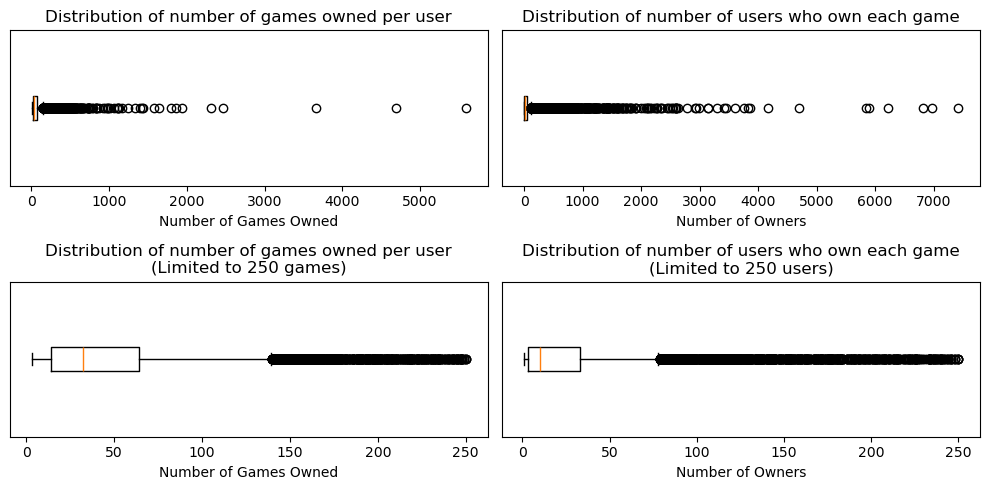

In [59]:
### Distribution of users and games
max_count = 250
gamesPerUser = playtime_df.value_counts(subset="user_id")
usersPerGame = playtime_df.value_counts(subset="item_id")
gamesPerUser_maxCount = gamesPerUser[gamesPerUser <= max_count]
usersPerGame_maxCount = usersPerGame[usersPerGame <= max_count]
n_bins = 20

# Stats
mean_gamesPerUser, max_gamesPerUser = gamesPerUser.agg(["mean", "max"])
mean_usersPerGame, max_usersPerGame = usersPerGame.agg(["mean", "max"])
# Finding number of outliers above 1.5 * IQR + Q3
q1_gamesPerUser, median_gamesPerUser, q3_gamesPerUser = gamesPerUser.quantile([0.25, 0.5, 0.75])
q1_usersPerGame, median_usersPerGame, q3_usersPerGame = usersPerGame.quantile([0.25, 0.5, 0.75])
highCutoff_gamesPerUser = (1.5 * (q3_gamesPerUser - q1_gamesPerUser)) + q3_gamesPerUser
numOutliers_gamesPerUser = len(gamesPerUser[gamesPerUser > highCutoff_gamesPerUser])
highCutoff_usersPerGame = (1.5 * (q3_usersPerGame - q1_usersPerGame)) + q3_usersPerGame
numOutliers_usersPerGame = len(usersPerGame[usersPerGame > highCutoff_usersPerGame])

print("#----- Stats on the number of games owned per user")
print(f"Mean number of games owned per user: {mean_gamesPerUser}")
print(f"Median number of games owned per user: {median_gamesPerUser}")
print(f"Max number of games owned per user: {max_gamesPerUser}")
print(f"Q3 Games owned: {q3_gamesPerUser}")
print(f"Cutoff to determine high outliers: {highCutoff_gamesPerUser}")
print(f"Number of high outliers: {numOutliers_gamesPerUser}")
print()
print("#----- Stats on the number of users who own each game")
print(f"Mean number of owners per game: {mean_usersPerGame}")
print(f"Median number of owners per game: {median_usersPerGame}")
print(f"Max number of owners per game: {max_usersPerGame}")
print(f"Q3 Number of Owners: {q3_usersPerGame}")
print(f"Cutoff to determine high outliers: {highCutoff_usersPerGame}")
print(f"Number of high outliers: {numOutliers_usersPerGame}")

fig,ax = plt.subplots(2,2, figsize=(10,5))
ax[0,0].boxplot(gamesPerUser, vert=False)
ax[0,0].set(title="Distribution of number of games owned per user", ylabel="", xlabel="Number of Games Owned", yticks=[])
ax[0,1].boxplot(usersPerGame, vert=False)
ax[0,1].set(title="Distribution of number of users who own each game", ylabel="", xlabel="Number of Owners", yticks=[])
ax[1,0].boxplot(gamesPerUser_maxCount, vert=False)
ax[1,0].set(title=f"Distribution of number of games owned per user\n(Limited to {max_count} games)", ylabel="", xlabel="Number of Games Owned", yticks=[])
ax[1,1].boxplot(usersPerGame_maxCount, vert=False)
ax[1,1].set(title=f"Distribution of number of users who own each game\n(Limited to {max_count} users)", ylabel="", xlabel="Number of Owners", yticks=[])
plt.tight_layout()
plt.savefig("images/EDA_Distributions_Own.png")
plt.show()

#----- Stats on the number of games played per user
Mean number of games played per user: 36.92263630089717
Median number of games played per user: 23.0
Max number of games played per user: 2207.0
Q1 Games played: 10.0
Q3 Games played: 47.0
Cutoff to determine high outliers: 102.5
Number of high outliers: 865

#----- Stats on the number of users who played each game
Mean number of players per game: 67.01853939621697
Median number of players per game: 7.0
Max number of players per game: 6876.0
Q1 Number of Players: 3.0
Q3 Number of Players: 30.0
Cutoff to determine high outliers: 70.5
Number of high outliers: 1198


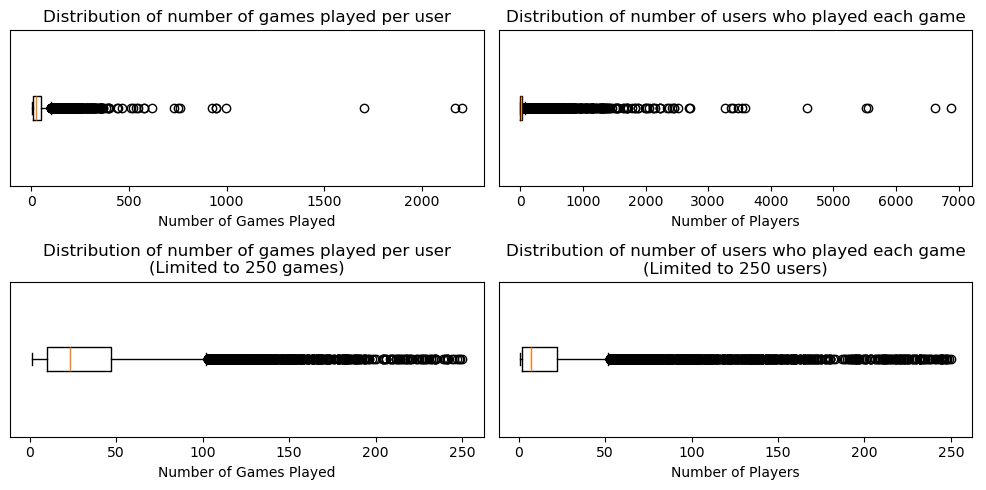

In [60]:
### Distribution of users and games PLAYED (playtime > 0)
max_count = 250
gamesPerUser = playtime_df[playtime_df["playtime_binary"] == 1].value_counts(subset="user_id")
usersPerGame = playtime_df[playtime_df["playtime_binary"] == 1].value_counts(subset="item_id")
gamesPerUser_maxCount = gamesPerUser[gamesPerUser <= max_count]
usersPerGame_maxCount = usersPerGame[usersPerGame <= max_count]
n_bins = 20

# Stats
mean_gamesPerUser, max_gamesPerUser = gamesPerUser.agg(["mean", "max"])
mean_usersPerGame, max_usersPerGame = usersPerGame.agg(["mean", "max"])
# Finding number of outliers above 1.5 * IQR + Q3
q1_gamesPerUser, median_gamesPerUser, q3_gamesPerUser = gamesPerUser.quantile([0.25, 0.5, 0.75])
q1_usersPerGame, median_usersPerGame, q3_usersPerGame = usersPerGame.quantile([0.25, 0.5, 0.75])
highCutoff_gamesPerUser = (1.5 * (q3_gamesPerUser - q1_gamesPerUser)) + q3_gamesPerUser
numOutliers_gamesPerUser = len(gamesPerUser[gamesPerUser > highCutoff_gamesPerUser])
highCutoff_usersPerGame = (1.5 * (q3_usersPerGame - q1_usersPerGame)) + q3_usersPerGame
numOutliers_usersPerGame = len(usersPerGame[usersPerGame > highCutoff_usersPerGame])

print("#----- Stats on the number of games played per user")
print(f"Mean number of games played per user: {mean_gamesPerUser}")
print(f"Median number of games played per user: {median_gamesPerUser}")
print(f"Max number of games played per user: {max_gamesPerUser}")
print(f"Q1 Games played: {q1_gamesPerUser}")
print(f"Q3 Games played: {q3_gamesPerUser}")
print(f"Cutoff to determine high outliers: {highCutoff_gamesPerUser}")
print(f"Number of high outliers: {numOutliers_gamesPerUser}")
print()
print("#----- Stats on the number of users who played each game")
print(f"Mean number of players per game: {mean_usersPerGame}")
print(f"Median number of players per game: {median_usersPerGame}")
print(f"Max number of players per game: {max_usersPerGame}")
print(f"Q1 Number of Players: {q1_usersPerGame}")
print(f"Q3 Number of Players: {q3_usersPerGame}")
print(f"Cutoff to determine high outliers: {highCutoff_usersPerGame}")
print(f"Number of high outliers: {numOutliers_usersPerGame}")

fig,ax = plt.subplots(2,2, figsize=(10,5))
ax[0,0].boxplot(gamesPerUser, vert=False)
ax[0,0].set(title="Distribution of number of games played per user", ylabel="", xlabel="Number of Games Played", yticks=[])
ax[0,1].boxplot(usersPerGame, vert=False)
ax[0,1].set(title="Distribution of number of users who played each game", ylabel="", xlabel="Number of Players", yticks=[])
ax[1,0].boxplot(gamesPerUser_maxCount, vert=False)
ax[1,0].set(title=f"Distribution of number of games played per user\n(Limited to {max_count} games)", ylabel="", xlabel="Number of Games Played", yticks=[])
ax[1,1].boxplot(usersPerGame_maxCount, vert=False)
ax[1,1].set(title=f"Distribution of number of users who played each game\n(Limited to {max_count} users)", ylabel="", xlabel="Number of Players", yticks=[])
plt.tight_layout()
plt.savefig("images/EDA_Distributions_Play.png")
plt.show()

Across all interactions, most users have either not played a game that they owned, or have played for fewer than ~ 5 hours
There is a second peak at about 314.1906602856942 hours


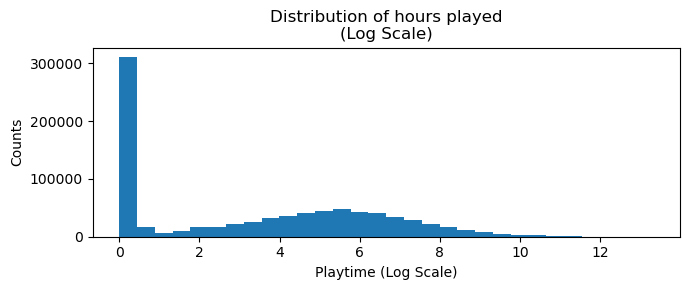

In [61]:
# Histograms: Hours played and logtime
n_bins = 30

print("Across all interactions, most users have either not played a game that they owned, or have played for fewer than ~ 5 hours")
print(f"There is a second peak at about {math.exp(5.75)} hours")

fig,ax = plt.subplots(1,1, figsize=(7,3))
ax.hist(playtime_df["playtime_log"], n_bins)
ax.set(title="Distribution of hours played\n(Log Scale)", ylabel="Counts", xlabel="Playtime (Log Scale)")

plt.tight_layout()
plt.savefig("images/EDA_Playtime_Log.png")
plt.show()

In [62]:
print(f"Mean number of log-hours played: {playtime_df["playtime_log"].mean()}")
print(f"Median number of log-hours played: {playtime_df["playtime_log"].median()}")

Mean number of log-hours played: 3.306869452754757
Median number of log-hours played: 3.4965075614664802


Across all interactions, most users have either not played a game that they owned, or have played for fewer than ~ 5 hours
There is a second peak at about 314.1906602856942 hours


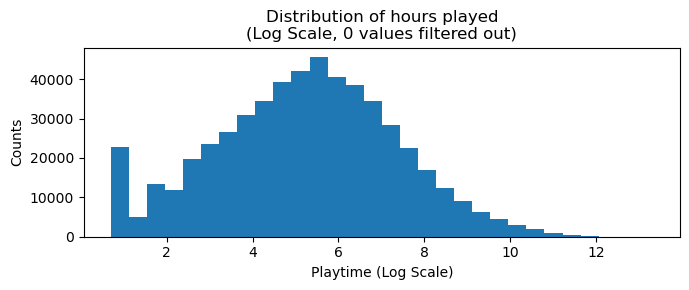

In [63]:
# Histograms: Hours played and logtime
n_bins = 30

print("Across all interactions, most users have either not played a game that they owned, or have played for fewer than ~ 5 hours")
print(f"There is a second peak at about {math.exp(5.75)} hours")

fig,ax = plt.subplots(1,1, figsize=(7,3))
ax.hist(playtime_df[playtime_df["playtime_log"] > 0]["playtime_log"], n_bins)
ax.set(title="Distribution of hours played\n(Log Scale, 0 values filtered out)", ylabel="Counts", xlabel="Playtime (Log Scale)")

plt.tight_layout()
plt.savefig("images/EDA_Playtime_Log_Nonzero.png")
plt.show()

In [64]:
### quartiles for hours played
playtime_df[playtime_df["playtime_log"] > 0]["playtime_log"].quantile([0.25, 0.5, 0.7])

0.25    3.806662
0.50    5.308268
0.70    6.368187
Name: playtime_log, dtype: float64

Across all interactions, most users have little to no recent playtime


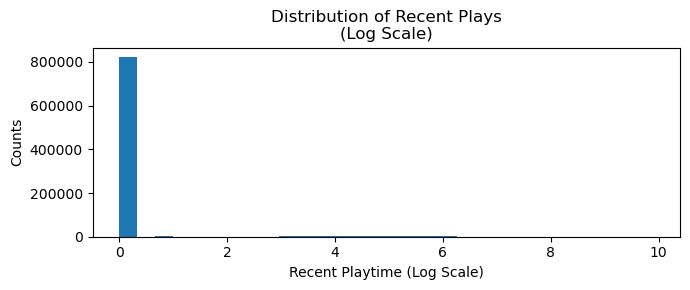

In [65]:
# Histograms: Hours played and logtime
n_bins = 30

print("Across all interactions, most users have little to no recent playtime")

fig,ax = plt.subplots(1,1, figsize=(7,3))
ax.hist(playtime_df["recent_playtime_log"], n_bins)
ax.set(title="Distribution of Recent Plays\n(Log Scale)", ylabel="Counts", xlabel="Recent Playtime (Log Scale)")

plt.tight_layout()
plt.savefig("images/EDA_RecentPlaytime_Log.png")
plt.show()

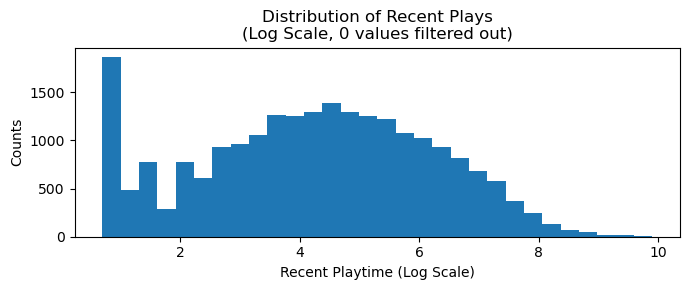

In [66]:
# Histograms: Hours played and logtime
n_bins = 30

fig,ax = plt.subplots(1,1, figsize=(7,3))
ax.hist(playtime_df[playtime_df["recent_playtime_log"] > 0]["recent_playtime_log"], n_bins)
ax.set(title="Distribution of Recent Plays\n(Log Scale, 0 values filtered out)", ylabel="Counts", xlabel="Recent Playtime (Log Scale)")

plt.tight_layout()
plt.savefig("images/EDA_RecentPlaytime_Log_Nonzero.png")
plt.show()

In [67]:
n_played = playtime_df["playtime_binary"].sum()
not_played = len(playtime_df) - playtime_df["playtime_binary"].sum()

print(n_played, n_played/len(playtime_df))
print(not_played, not_played/len(playtime_df))

535009 0.632295952073955
311128 0.36770404792604505


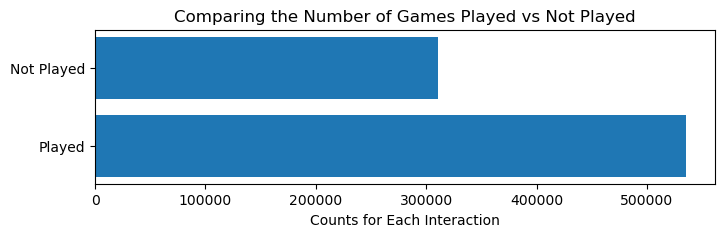

In [68]:
### Barplot: Played vs NotPlayed
playtimeCounts = playtime_df["playtime_binary"].map(lambda x: "Played" if x==1 else "Not Played").value_counts()

fig,ax = plt.subplots(1,1, figsize=(8,2))
ax.barh(playtimeCounts.index, playtimeCounts, align="center")
ax.set(title="Comparing the Number of Games Played vs Not Played", ylabel="", xlabel="Counts for Each Interaction")
# plt.tight_layout()
plt.savefig("images/EDA_Played_vs_NotPlayed.png")

In [69]:
### Are there any games in the playtime_df that have ZERO playtime?
item_totalPlaytimes = playtime_df.groupby("item_id").agg("sum")["playtime"]

In [70]:
len(item_totalPlaytimes[item_totalPlaytimes == 0])

1686

In [71]:
### Game analysis: Explore most common genres, tags, specs

In [72]:
genre_counts = game_genres_df.sum(axis=0)
game_genre_counts = game_genres_df.sum(axis=1)
###
tag_counts = game_tags_df.sum(axis=0)
game_tag_counts = game_tags_df.sum(axis=1)
###
spec_counts = game_specs_df.sum(axis=0)
game_spec_counts = game_specs_df.sum(axis=1)

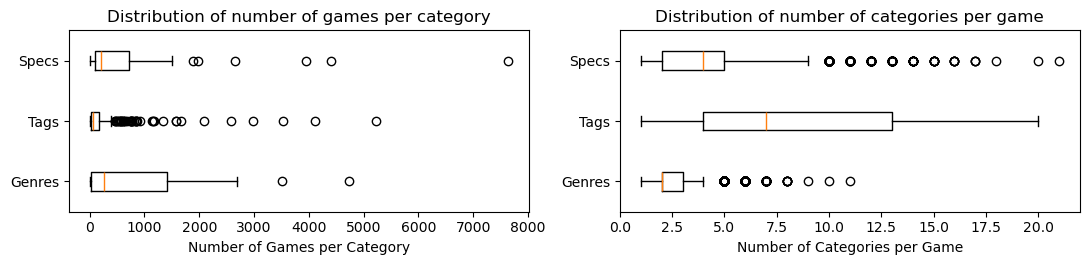

In [73]:
fig,ax = plt.subplots(1,2, figsize=(11,2.75))
labels = ["Genres", "Tags", "Specs"]

ax[0].boxplot([genre_counts, tag_counts, spec_counts], vert=False, labels=labels)
ax[0].set(title="Distribution of number of games per category", ylabel="", xlabel="Number of Games per Category", )
ax[1].boxplot([game_genre_counts, game_tag_counts, game_spec_counts], vert=False, labels=labels)
ax[1].set(title="Distribution of number of categories per game", ylabel="", xlabel="Number of Categories per Game")
plt.tight_layout()

plt.savefig("images/EDA_Category_Distributions.png")
plt.show()

In [74]:
print(len(genre_counts))
print(len(tag_counts))
print(len(spec_counts))

21
337
39


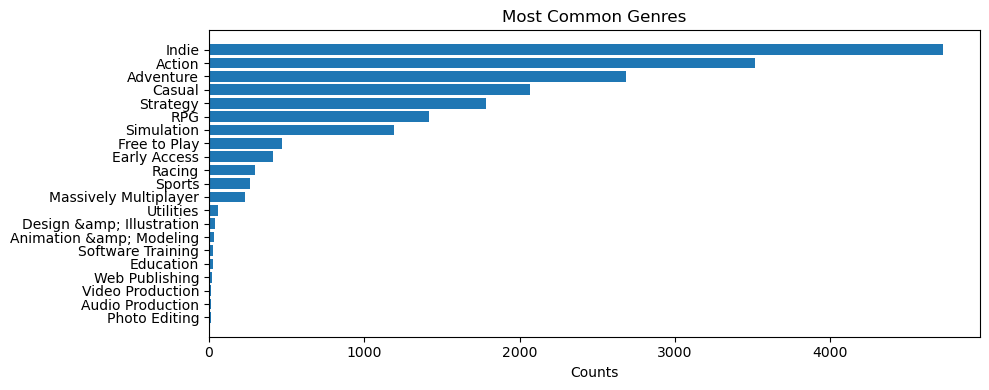

In [75]:
# Genre analysis specifically 
col = "Genres"
#-----
sorted_df = genre_counts.sort_values()
# genres_bot = genre_counts.sort_values().head(n_outputs)
df = sorted_df

fig,ax = plt.subplots(1,1, figsize = (10,4))

ax.barh(df.index, df)
ax.set(title=f"Most Common {col}", xlabel="Counts")

plt.tight_layout()
plt.savefig("images/EDA_Genre_Distributions.png")
plt.show()

In [76]:
### Find the tags presnt on at least n% of all games for OHE purposes
cutoff = 0.75 * n_games
print(f"Cutoff = {cutoff}")
game_genres_df.iloc[:,list(np.where(game_genres_df.sum(axis=0) > cutoff)[0])].head(10)

Cutoff = 7251.75


""
item_id
282010.0
70.0
1640.0
1630.0
2400.0
3800.0
1520.0
2420.0
4000.0


In [77]:
### Alternatively, take the top N values
game_genres_df.loc[:,list((game_genres_df.sum(axis=0) > cutoff).sort_values().tail(15).index)].head(10)

,Utilities,Massively Multiplayer,Animation &amp; Modeling,Software Training,Free to Play,Early Access,Web Publishing,Sports,RPG,Strategy,Audio Production,Video Production,Photo Editing,Adventure,Design &amp; Illustration
item_id,,,,,,,,,,,,,,,
282010.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
70.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1640.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1630.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2400.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3800.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1520.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2420.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


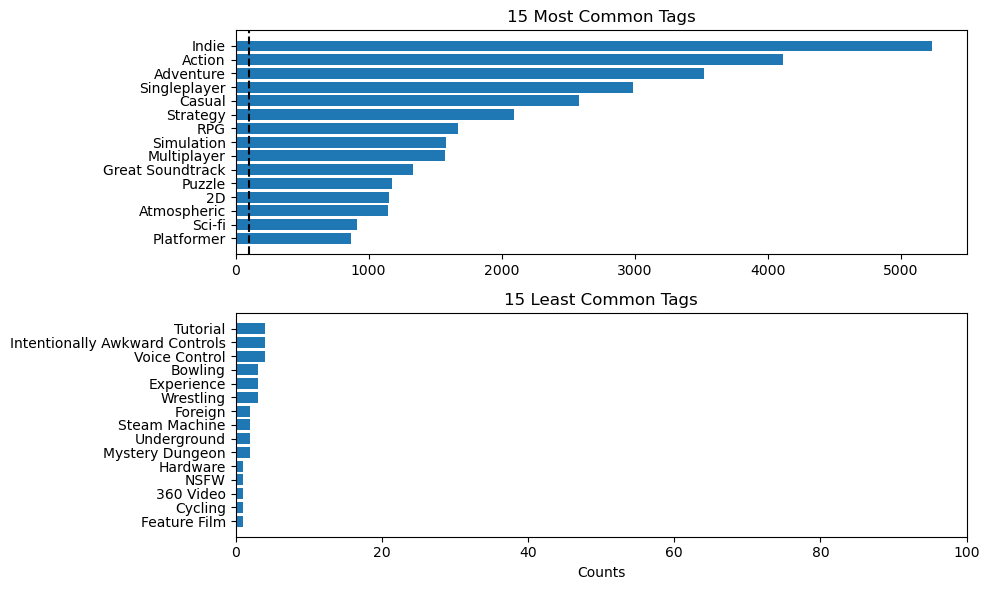

In [78]:
# Genre analysis specifically --> top 10 and bottom 10 genres in terms of representation
col = "Tags"
xlim_max = 100
n_outputs = 15
#-----
sorted_df = tag_counts.sort_values()
df_bot = sorted_df.head(n_outputs)
df_top = sorted_df.tail(n_outputs)

fig,ax = plt.subplots(2,1, figsize = (10,6))

ax[0].barh(df_top.index, df_top)
ax[0].axvline(xlim_max, color="k", linestyle="--")
ax[0].set(title=f"{n_outputs} Most Common {col}")
# ax[0].legend()
ax[1].barh(df_bot.index, df_bot)
ax[1].set(title=f"{n_outputs} Least Common {col}", xlim=(0,xlim_max), xlabel="Counts")

plt.tight_layout()
plt.savefig("images/EDA_Tag_Distributions.png")
plt.show()

In [79]:
### Find the tags presnt on at least 33% of all games for OHE purposes
cutoff = 0.2 * n_games
print(f"Cutoff = {cutoff}")
game_tags_df.iloc[:,list(np.where(game_tags_df.sum(axis=0) > cutoff)[0])].head(10)

Cutoff = 1933.8000000000002


,Strategy,Singleplayer,Adventure,Indie,Casual,Action
item_id,,,,,,
282010.0,0,1,0,1,0,1
70.0,0,1,1,0,0,1
1640.0,1,0,0,0,0,0
1630.0,1,0,0,0,0,0
2400.0,1,1,1,1,0,1
3800.0,0,1,0,0,0,1
1520.0,1,1,0,1,0,0
2420.0,0,1,0,1,0,1
4000.0,0,1,1,1,0,1


In [80]:
### Alternatively, take the top N values
game_tags_df.loc[:,list((game_tags_df.sum(axis=0) > cutoff).sort_values().tail(15).index)].head(10)

,Music-Based Procedural Generation,LEGO,Retro,Crowdfunded,Rome,Tactical RPG,Underground,Gun Customization,Violent,Casual,Strategy,Indie,Singleplayer,Adventure,Action
item_id,,,,,,,,,,,,,,,
282010.0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1
70.0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1
1640.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1630.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2400.0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
3800.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1520.0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
2420.0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1
4000.0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1


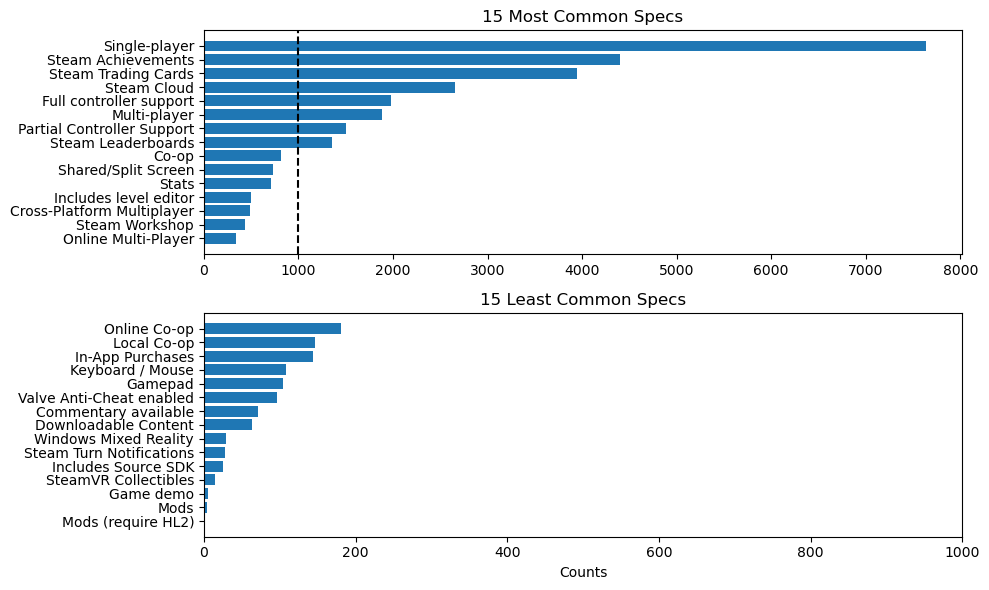

In [81]:
# Genre analysis specifically --> top 10 and bottom 10 genres in terms of representation
col = "Specs"
xlim_max = 1000
n_outputs = 15
#-----
sorted_df = spec_counts.sort_values()
df_bot = sorted_df.head(n_outputs)
df_top = sorted_df.tail(n_outputs)

fig,ax = plt.subplots(2,1, figsize = (10,6))

ax[0].barh(df_top.index, df_top)
ax[0].axvline(xlim_max, color="k", linestyle="--")
ax[0].set(title=f"{n_outputs} Most Common {col}")
# ax[0].legend()
ax[1].barh(df_bot.index, df_bot)
ax[1].set(title=f"{n_outputs} Least Common {col}", xlim=(0,xlim_max), xlabel="Counts")

plt.tight_layout()
plt.savefig("images/EDA_Spec_Distributions.png")
plt.show()

In [82]:
### Find the tags presnt on at least 33% of all games for OHE purposes
cutoff = 0.2 * n_games
print(f"Cutoff = {cutoff}")
game_specs_df.iloc[:,list(np.where(game_specs_df.sum(axis=0) > cutoff)[0])].head(10)

Cutoff = 1933.8000000000002


,Steam Cloud,Single-player,Steam Achievements,Steam Trading Cards,Full controller support
item_id,,,,,
282010.0,0,1,0,1,0
70.0,0,1,0,0,0
1640.0,0,1,0,0,0
1630.0,0,1,0,0,0
2400.0,0,1,0,1,0
3800.0,0,1,0,1,0
1520.0,0,1,0,0,0
2420.0,0,1,0,0,0
4000.0,1,1,1,1,0


In [83]:
### Alternatively, take the top N values
game_specs_df.loc[:,list((game_specs_df.sum(axis=0) > cutoff).sort_values().head(15).index)].head(10)

,Valve Anti-Cheat enabled,Shared/Split Screen,Online Co-op,Commentary available,Room-Scale,Steam Turn Notifications,Cross-Platform Multiplayer,SteamVR Collectibles,Game demo,Online Multi-Player,Gamepad,Oculus Rift,Seated,Standing,Mods (require HL2)
item_id,,,,,,,,,,,,,,,
282010.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
70.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1640.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1630.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2400.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3800.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1520.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2420.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4000.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [84]:
### Save data frames
playtime_df.to_csv("data/playtime_df.csv", index=False)
game_genres_df.to_csv("data/game_genres_df.csv", index=True)
game_tags_df.to_csv("data/game_tags_df.csv", index=True)
game_specs_df.to_csv("data/game_specs_df.csv", index=True)

In [91]:
### Extract all users from playtime_df and bin them according to quartiles based on counts/hours played
col = "user_id"
c_col = "count"
p_col = "play"
pc_col = "fracPlayed"

quartiles = [round(i,1) for i in np.linspace(0.1,1,8)]
print(quartiles)

c_quartiles = [0] + list(playtime_df[col].value_counts().quantile(quartiles))
print(c_quartiles)

p_quartiles = [0] + list(playtime_df[playtime_df["playtime"] > 0][col].value_counts().quantile(quartiles))
print(p_quartiles)

user_bins = pd.merge(playtime_df[col].value_counts(), playtime_df[playtime_df["playtime"] > 0][col].value_counts().rename(p_col), on=col)
user_bins[pc_col] = user_bins[p_col] / user_bins[c_col]

pc_quartiles = [0] + quartiles
print(pc_quartiles)

user_bins["count_bin"] = pd.cut(user_bins[c_col], bins= c_quartiles, labels=[i for i in c_quartiles[1:]])
user_bins["play_bin"] = pd.cut(user_bins[p_col], bins= p_quartiles, labels=[i for i in p_quartiles[1:]])
user_bins["fracPlayed_bin"] = pd.cut(user_bins[pc_col], bins= pc_quartiles, labels=[i for i in pc_quartiles[1:]])

# Save df
user_bins.to_csv("data/user_bins.csv")

user_bins.head(10)

[0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.9, 1.0]
[0, 6.0, 11.0, 25.0, 33.0, 44.0, 59.0, 123.0, 5588.0]
[0, 4.0, 8.0, 17.0, 23.0, 31.0, 41.0, 81.0, 2207.0]
[0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.9, 1.0]


,count,play,fracPlayed,count_bin,play_bin,fracPlayed_bin
user_id,,,,,,
u5838,5588,2170,0.388332,5588.0,2207.0,0.4
u12139,4688,2207,0.470776,5588.0,2207.0,0.5
u1757,3660,1704,0.465574,5588.0,2207.0,0.5
u6033,2469,925,0.374646,5588.0,2207.0,0.4
u6745,2310,193,0.083550,5588.0,2207.0,0.1
u2715,1942,749,0.385685,5588.0,2207.0,0.4
u12345,1859,948,0.509952,5588.0,2207.0,0.6
u4045,1794,945,0.526756,5588.0,2207.0,0.6
u4652,1640,762,0.464634,5588.0,2207.0,0.5


In [92]:
user_bins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14490 entries, u5838 to u11817
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   count           14490 non-null  int64   
 1   play            14490 non-null  int64   
 2   fracPlayed      14490 non-null  float64 
 3   count_bin       14490 non-null  category
 4   play_bin        14490 non-null  category
 5   fracPlayed_bin  14490 non-null  category
dtypes: category(3), float64(1), int64(2)
memory usage: 496.3+ KB


In [93]:
### Repeat but with items
col = "item_id"
c_col = "count"
p_col = "play"
pc_col = "fracPlayed"

playtime_moreThan4Count = playtime_df[playtime_df[col].isin((playtime_df[col].value_counts()[playtime_df[col].value_counts() >=4].index))]

c_quartiles = [0] + list(playtime_moreThan4Count[col].value_counts().quantile(quartiles))
print(c_quartiles)

p_quartiles = [0] + list(playtime_moreThan4Count[playtime_moreThan4Count["playtime"] > 0][col].value_counts().quantile(quartiles))
print(p_quartiles)

item_bins = pd.merge(playtime_moreThan4Count[col].value_counts(), playtime_moreThan4Count[playtime_df["playtime"] > 0][col].value_counts().rename(p_col), on=col)
item_bins[pc_col] = item_bins[p_col] / item_bins[c_col]

pc_quartiles = [0] + quartiles
print(pc_quartiles)

item_bins["count_bin"] = pd.cut(item_bins[c_col], bins= c_quartiles, labels=[i for i in c_quartiles[1:]])
item_bins["play_bin"] = pd.cut(item_bins[p_col], bins= p_quartiles, labels=[i for i in p_quartiles[1:]])
item_bins["fracPlayed_bin"] = pd.cut(item_bins[pc_col], bins= pc_quartiles, labels=[i for i in pc_quartiles[1:]])

# Save df
item_bins.to_csv("data/item_bins.csv")

item_bins.head(10)

[0, 5.0, 7.0, 15.0, 22.0, 34.0, 55.0, 251.0, 7423.0]
[0, 2.0, 4.0, 7.0, 11.0, 17.0, 30.0, 158.10000000000036, 6876.0]
[0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.9, 1.0]


,count,play,fracPlayed,count_bin,play_bin,fracPlayed_bin
item_id,,,,,,
205790,7423,528,0.071130,7423.0,6876.0,0.1
730,6969,6876,0.986655,7423.0,6876.0,1.0
4000,6811,6620,0.971957,7423.0,6876.0,1.0
304930,6214,5555,0.893949,7423.0,6876.0,0.9
550,5895,5520,0.936387,7423.0,6876.0,1.0
223530,5846,225,0.038488,7423.0,6876.0,0.1
105600,4696,4584,0.976150,7423.0,6876.0,1.0
230410,4163,3361,0.807350,7423.0,6876.0,0.9
620,3865,3594,0.929884,7423.0,6876.0,1.0


In [89]:
item_bins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6660 entries, 205790 to 301830
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   count           6660 non-null   int64   
 1   play            6660 non-null   int64   
 2   fracPlayed      6660 non-null   float64 
 3   count_bin       6660 non-null   category
 4   play_bin        6660 non-null   category
 5   fracPlayed_bin  6660 non-null   category
dtypes: category(3), float64(1), int64(2)
memory usage: 228.8 KB


In [1]:
### Grouping items by lower dimensional representations of genres and tags
item_df

NameError: name 'item_df' is not defined